<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210927_DictL_%E5%85%A8%E3%83%A6%E3%83%8B%E3%83%83%E3%83%88%E5%AD%A6%E7%BF%92_%E3%83%86%E3%82%B9%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import math
import statistics
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data',
 'notebook',
 'C0002_21_09_2021.csv',
 'C0002_23_09_2021.csv',
 'ref',
 'C0002_27_09_2021.csv',
 'C0002_27_09_2021_2.csv']

In [3]:
#データの読み込み
dataframe_train = pd.read_csv(
    os.path.join(DIR, 'data', 'Train_Unit_20210903', 'dataset_train_all.csv'),
    encoding='utf-8')
dataframe_test = pd.read_csv(
    os.path.join(DIR, 'data', 'Test_Unit_20210903', 'dataset_test_all.csv'),
    encoding='utf-8')

In [4]:
def data_processed(dataframe):
  #不必要なIndex列と空白列を削除。
  df = dataframe.drop(dataframe.columns[[0, 7]], axis=1)

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
            'Voltage Measured (V)' : 'VM',
            'Voltage Charge (V)' : 'VC',
            'Current Measured (Amps)' : 'CM', 
            'Current Charge (Amps)' : 'CC',
            'Temperature (degree C)': 'Temp', 
            'unit' : 'unit_name', 
            'charge_mode' : 'mode', 
            'Cycle_num' : 'Cycle',
            'Voltage Load (V)' : 'VL',
            'Current Load (Amps)' : 'CL'
  }
  
  df = df.rename(columns=col_list)
  
  #ユニットとサイクルでソート。
  df = df.sort_values(['unit_name', 'Cycle']).reset_index(drop=True)

  return df

In [5]:
df_train_base = data_processed(dataframe_train)
df_test_base = data_processed(dataframe_test)

In [6]:
df_train_base.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


In [7]:
#充電と放電について、データセットを分ける
train_c = df_train_base[df_train_base['mode'] == 'Charge']
train_d = df_train_base[df_train_base['mode'] == 'Discharge']

In [37]:
train_c['unit_name'].unique()

array(['Train_Unit_1', 'Train_Unit_2', 'Train_Unit_3'], dtype=object)

全ユニットに対して自動特徴量を抽出し、学習

学習用データ加工

In [8]:
from sklearn.decomposition import DictionaryLearning
from xgboost import XGBRegressor

In [9]:
#関数化：グループIDを付与する。
def add_group(max_value, df, interval):
  group_list = []
  for i in np.arange(1, max_value/interval):
      lower = interval*i-interval
      upper = interval*i
      tmp_df = df[ (lower < df['Time']) & (upper > df['Time'])]
      tmp_df['group_id'] = f'{lower} -- {upper}'
      group_list.append(tmp_df)
  df_add_group = pd.concat(group_list)
  return df_add_group

In [10]:
#max_value = 11000
#base_df = train_c
#interval = 50
#col = 'VM'
#mode = C

#DictLによる特徴量の抽出とデータフレーム化
def autofe_by_dictl(max_value, base_df, interval, col, mode):

  add_group_id = add_group(max_value, base_df, interval=interval)
  add_group_id = add_group_id.reset_index(drop=True)

  #サイクル、グループID毎にグループ化し、平均値をとる。
  grouped_df_mean = add_group_id.groupby(['Cycle', 'group_id']).mean().sort_values(['Cycle','Time'])

  #ピボットテーブルを作成
  pt = pd.pivot_table(grouped_df_mean, index='group_id', columns='Cycle', values=col)
  #欠測値は削除。
  pt = pt.dropna()

  #学習データの設定
  X = np.asarray(pt.values)
  X_train = X

  #辞書学習による特徴量抽出
  n_components = 10
  dict_learner = DictionaryLearning(
        n_components=n_components,
        fit_algorithm='cd',
        transform_algorithm = 'lasso_lars',
        random_state = 42,
        positive_code = False,
        positive_dict = False,
        alpha = 1
    )

  X_train_transformed = dict_learner.fit_transform(X_train)

  cols = []
  for i in np.arange(0, n_components):
    c = f'Component_{i}_{col}_{mode}'
    cols.append(c)
  
  df_dict = pd.DataFrame(dict_learner.components_.T, columns=cols)

  return df_dict

In [11]:
train_c.columns
col_charge = train_c.columns[1:6]
col_charge

Index(['VM', 'VC', 'CM', 'CC', 'Temp'], dtype='object')

In [12]:
#連続処理(充電)

#max_value = 11000
#base_df = train_c
#interval = 50
#col = 'VM'
#mode = C
df_charge = []
for col in col_charge:
  tmp_df = autofe_by_dictl(11000, train_c, 50, col, 'C')
  df_charge.append(tmp_df)

In [13]:
#type(df_charge)
len(df_charge)

5

In [14]:
df_charge[0]

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C
0,-0.089592,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883
1,-0.089598,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149
2,-0.089607,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279
3,-0.089618,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180
4,-0.089639,0.001313,-0.100524,-0.046041,0.085471,0.053220,-0.060714,0.023560,-0.064925,0.065598
...,...,...,...,...,...,...,...,...,...,...
119,-0.090065,0.056763,0.070464,-0.041210,0.141170,-0.079162,-0.005804,0.114174,0.064202,0.103529
120,-0.090040,0.062886,-0.022545,-0.157213,0.186991,-0.057474,-0.115718,0.092959,-0.093449,-0.081199
121,-0.090024,-0.125664,0.141918,0.051918,0.000352,-0.050974,0.168064,0.052073,0.067407,0.137068
122,-0.090055,0.111495,-0.130722,-0.053229,0.096370,-0.051838,0.077074,-0.011558,0.121960,-0.023937


In [15]:
df_merge_charge = pd.concat([df_charge[0],df_charge[1], df_charge[2], df_charge[3],df_charge[4]],axis=1)
df_merge_charge

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C,Component_0_VC_C,Component_1_VC_C,Component_2_VC_C,Component_3_VC_C,Component_4_VC_C,Component_5_VC_C,Component_6_VC_C,Component_7_VC_C,Component_8_VC_C,Component_9_VC_C,Component_0_CM_C,Component_1_CM_C,Component_2_CM_C,Component_3_CM_C,Component_4_CM_C,Component_5_CM_C,Component_6_CM_C,Component_7_CM_C,Component_8_CM_C,Component_9_CM_C,Component_0_CC_C,Component_1_CC_C,Component_2_CC_C,Component_3_CC_C,Component_4_CC_C,Component_5_CC_C,Component_6_CC_C,Component_7_CC_C,Component_8_CC_C,Component_9_CC_C,Component_0_Temp_C,Component_1_Temp_C,Component_2_Temp_C,Component_3_Temp_C,Component_4_Temp_C,Component_5_Temp_C,Component_6_Temp_C,Component_7_Temp_C,Component_8_Temp_C,Component_9_Temp_C
0,-0.089592,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,-0.090319,0.110575,0.091371,-0.122486,-0.089230,0.090016,0.100300,0.095594,-0.115494,0.106781,-0.089710,0.110399,-0.100082,-0.013584,0.041541,0.225464,0.042568,-0.017386,0.099021,-0.135266,-0.089987,0.110770,-0.100426,-0.015884,-0.061260,-0.139627,0.008426,-0.196119,0.128815,0.108432,-0.087288,-0.115770,0.095684,-0.082895,0.099277,-0.067441,0.076435,0.068525,0.066700,-0.054938
1,-0.089598,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,-0.090232,0.110555,0.091326,-0.122408,-0.089343,0.090001,0.100281,0.095617,-0.115453,0.106814,-0.089726,0.107616,-0.099609,-0.182644,-0.071249,-0.044111,0.137277,-0.050273,-0.034339,0.099027,-0.090004,0.107966,-0.099981,0.059103,0.196743,-0.010345,-0.150371,-0.205895,0.057005,-0.140823,-0.086662,-0.116162,0.095871,-0.083475,0.098106,-0.069714,0.076636,-0.160202,-0.091632,0.051945
2,-0.089607,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,-0.090166,0.110474,0.091334,-0.115221,-0.089394,0.089996,0.100275,0.095625,-0.115449,0.106814,-0.089753,0.105611,-0.099098,-0.034623,-0.016331,-0.086349,-0.214332,-0.093720,0.062081,0.005421,-0.090018,0.105948,-0.099456,-0.050140,-0.048995,0.064374,-0.089069,-0.019580,-0.038220,-0.017709,-0.086161,-0.116751,0.095892,-0.083541,0.096122,-0.073547,0.075915,-0.023539,-0.138951,0.040876
3,-0.089618,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180,-0.090139,0.104028,0.091341,-0.053623,-0.089533,0.089975,0.100340,0.095601,-0.099444,0.106628,-0.089754,0.104199,-0.098616,0.002165,-0.069081,-0.150909,0.003696,0.061399,0.064368,0.007770,-0.090031,0.104557,-0.098995,0.108640,0.075296,0.135549,0.111645,-0.158899,-0.056584,-0.166964,-0.086745,-0.108897,0.086921,-0.081556,0.093059,-0.080065,0.075246,-0.089805,-0.169567,0.117456
4,-0.089639,0.001313,-0.100524,-0.046041,0.085471,0.053220,-0.060714,0.023560,-0.064925,0.065598,-0.090145,0.110521,0.091336,-0.111273,-0.089713,0.090000,0.100263,0.095632,-0.115434,0.106876,-0.089740,0.103783,-0.099203,0.151699,-0.053978,0.162292,0.005935,0.067219,-0.029149,-0.152249,-0.090007,0.104116,-0.099562,-0.128966,0.054548,0.087103,-0.047573,-0.095703,0.019500,0.058023,-0.088057,-0.089502,0.077747,-0.081026,0.091396,-0.086759,0.074373,0.151345,0.044999,0.053521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-0.090065,0.056763,0.070464,-0.041210,0.141170,-0.079162,-0.005804,0.114174,0.064202,0.103529,-0.088945,0.110752,0.091624,-0.122886,-0.092023,0.090269,0.100445,0.095972,-0.115915,0.107567,-0.089989,0.056751,-0.063141,-0.061543,-0.074675,-0.013406,0.120689,-0.024082,-0.068063,0.220971,-0.089850,0.056596,-0.062960,0.000878,0.148330,0.013533,0.051718,0.046348,0.040874,-0.039351,-0.093545,-0.083774,0.113336,-0.086685,0.074702,-0.093263,0.117166,-0.130188,0.114056,0.178130
120,-0.090040,0.062886,-0.022545,-0.157213,0.186991,-0.0

In [16]:
train_d.columns
col_discharge = list([train_d.columns[1], train_d.columns[3], train_d.columns[5], train_d.columns[-2]])
col_discharge

['VM', 'CM', 'Temp', 'VL']

In [17]:
#連続処理(放電)
df_discharge = []
for col in col_discharge:
  tmp_df = autofe_by_dictl(11000, train_d, 50, col, 'D')
  df_discharge.append(tmp_df)

In [18]:
df_merge_discharge = pd.concat([df_discharge[0],df_discharge[1], df_discharge[2], df_discharge[3]],axis=1)
df_merge_discharge

,Component_0_VM_D,Component_1_VM_D,Component_2_VM_D,Component_3_VM_D,Component_4_VM_D,Component_5_VM_D,Component_6_VM_D,Component_7_VM_D,Component_8_VM_D,Component_9_VM_D,Component_0_CM_D,Component_1_CM_D,Component_2_CM_D,Component_3_CM_D,Component_4_CM_D,Component_5_CM_D,Component_6_CM_D,Component_7_CM_D,Component_8_CM_D,Component_9_CM_D,Component_0_Temp_D,Component_1_Temp_D,Component_2_Temp_D,Component_3_Temp_D,Component_4_Temp_D,Component_5_Temp_D,Component_6_Temp_D,Component_7_Temp_D,Component_8_Temp_D,Component_9_Temp_D,Component_0_VL_D,Component_1_VL_D,Component_2_VL_D,Component_3_VL_D,Component_4_VL_D,Component_5_VL_D,Component_6_VL_D,Component_7_VL_D,Component_8_VL_D,Component_9_VL_D
0,-0.086757,0.092419,0.084925,-0.026482,-0.002566,-0.071721,-0.022561,0.054619,-0.104856,-0.078625,0.092911,-0.090317,0.104725,0.120628,-0.096542,0.098000,0.081357,0.166722,0.006425,-0.284748,-0.092204,0.102144,0.100302,-0.127281,0.107331,-0.158458,0.096975,0.079981,0.072449,-0.112120,-0.086472,0.045638,-0.072641,-0.092018,0.081547,-0.025539,0.014991,-0.123744,-0.068117,-0.052658
1,-0.087923,0.092301,0.084167,0.117668,-0.009323,0.028246,-0.055958,0.066295,0.023217,0.016425,0.092520,-0.089087,0.104867,0.114113,-0.097598,0.097591,-0.068206,-0.041264,-0.043107,-0.048151,-0.089917,0.092050,0.097640,-0.125775,0.101695,-0.076331,0.095627,0.089702,0.075286,-0.101196,-0.089347,-0.247352,-0.072076,-0.090681,0.083406,-0.152960,0.071699,0.039294,0.107967,0.113073
2,-0.088191,0.092179,0.084781,-0.004728,-0.013884,0.013364,-0.015683,0.008074,-0.072198,0.070815,0.092833,-0.089219,0.102938,0.101239,-0.096361,0.100235,0.013412,-0.200157,0.028946,0.086010,-0.088949,0.090386,0.099436,-0.102833,0.099709,-0.078552,0.093249,0.089512,0.076311,-0.096991,-0.088731,0.140780,-0.074019,-0.091773,0.083895,-0.136029,-0.255212,-0.115993,-0.080185,0.035647
3,-0.088266,0.092300,0.085672,-0.015532,-0.002263,0.022200,-0.128996,-0.215979,-0.006894,0.001167,0.092947,-0.089404,0.105120,0.083495,-0.096380,0.098629,-0.071940,0.113814,0.081512,0.072928,-0.088202,0.092763,0.099903,-0.076182,0.096001,-0.081382,0.096191,0.089982,0.077877,-0.096572,-0.088013,-0.064372,-0.076798,-0.093508,0.084065,-0.044519,0.042529,0.097853,-0.059213,-0.085652
4,-0.088424,0.092190,0.084766,-0.043652,-0.065629,0.004859,0.162786,-0.001957,-0.087289,-0.107853,0.092387,-0.089209,0.105121,0.099359,-0.097613,0.098381,-0.059061,0.084151,0.087348,-0.016715,-0.088848,0.089973,0.099084,-0.100861,0.095120,-0.080842,0.095305,0.089369,0.078721,-0.097737,-0.088972,0.137796,-0.074141,-0.091618,0.084213,0.051553,0.020529,-0.060856,0.120925,0.104816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-0.093776,0.081874,0.092506,-0.016651,0.221884,-0.074201,-0.029805,0.077597,0.036807,-0.043760,0.067577,-0.089969,0.075999,0.083912,-0.067938,0.072033,0.033727,-0.046823,-0.068248,-0.130840,-0.089108,0.054447,0.077274,-0.093497,0.063326,-0.104466,0.096103,0.093949,0.111962,-0.059544,-0.091237,-0.031256,-0.102532,-0.080737,0.109002,-0.095942,-0.175219,-0.092124,0.057854,0.019203
120,-0.093939,0.082214,0.092547,0.005251,0.142147,-0.048016,0.087803,-0.049284,-0.112896,0.104917,0.067546,-0.089962,0.075981,0.083933,-0.067946,0.072060,0.011476,0.023552,-0.044962,0.019334,-0.089485,0.055466,0.077886,-0.094242,0.064107,-0.105354,0.096147,0.095076,0.112028,-0.060615,-0.091088,0.043197,-0.102332,-0.081349,0.109094,0.087194,-0.055054,0.058708,-0.011990,0.032803
121,-0.093808,0.080868,0.092575,-0.026099,0.141965,0.062898,-0.128130,-0.028837,0.089578,0.056490,0.067556,-0.089960,0.076035,0.083897,-0.067938,0.071997,-0.021524,0.043583,0.114628,-0.186008,-0.088228,0.056472,0.078013,-0.094812,0.064945,-0.106218,0.095036,0.093438,0.114402,-0.061219,-0.091243,-0.129135,-0.102296,-0.078534,0.108655,-0.081908,-0.046596,-0.147995,0.072646,0.117600
122,-0.093728,0.080127,0.092591,0.168081,0.053493,0.118640,-0.078414,0.031576,-0.

In [19]:
df_dict_merge = pd.concat([df_merge_charge, df_merge_discharge], axis=1)
df_dict_merge

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C,Component_0_VC_C,Component_1_VC_C,Component_2_VC_C,Component_3_VC_C,Component_4_VC_C,Component_5_VC_C,Component_6_VC_C,Component_7_VC_C,Component_8_VC_C,Component_9_VC_C,Component_0_CM_C,Component_1_CM_C,Component_2_CM_C,Component_3_CM_C,Component_4_CM_C,Component_5_CM_C,Component_6_CM_C,Component_7_CM_C,Component_8_CM_C,Component_9_CM_C,Component_0_CC_C,Component_1_CC_C,Component_2_CC_C,Component_3_CC_C,Component_4_CC_C,Component_5_CC_C,Component_6_CC_C,Component_7_CC_C,Component_8_CC_C,Component_9_CC_C,...,Component_0_VM_D,Component_1_VM_D,Component_2_VM_D,Component_3_VM_D,Component_4_VM_D,Component_5_VM_D,Component_6_VM_D,Component_7_VM_D,Component_8_VM_D,Component_9_VM_D,Component_0_CM_D,Component_1_CM_D,Component_2_CM_D,Component_3_CM_D,Component_4_CM_D,Component_5_CM_D,Component_6_CM_D,Component_7_CM_D,Component_8_CM_D,Component_9_CM_D,Component_0_Temp_D,Component_1_Temp_D,Component_2_Temp_D,Component_3_Temp_D,Component_4_Temp_D,Component_5_Temp_D,Component_6_Temp_D,Component_7_Temp_D,Component_8_Temp_D,Component_9_Temp_D,Component_0_VL_D,Component_1_VL_D,Component_2_VL_D,Component_3_VL_D,Component_4_VL_D,Component_5_VL_D,Component_6_VL_D,Component_7_VL_D,Component_8_VL_D,Component_9_VL_D
0,-0.089592,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,-0.090319,0.110575,0.091371,-0.122486,-0.089230,0.090016,0.100300,0.095594,-0.115494,0.106781,-0.089710,0.110399,-0.100082,-0.013584,0.041541,0.225464,0.042568,-0.017386,0.099021,-0.135266,-0.089987,0.110770,-0.100426,-0.015884,-0.061260,-0.139627,0.008426,-0.196119,0.128815,0.108432,...,-0.086757,0.092419,0.084925,-0.026482,-0.002566,-0.071721,-0.022561,0.054619,-0.104856,-0.078625,0.092911,-0.090317,0.104725,0.120628,-0.096542,0.098000,0.081357,0.166722,0.006425,-0.284748,-0.092204,0.102144,0.100302,-0.127281,0.107331,-0.158458,0.096975,0.079981,0.072449,-0.112120,-0.086472,0.045638,-0.072641,-0.092018,0.081547,-0.025539,0.014991,-0.123744,-0.068117,-0.052658
1,-0.089598,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,-0.090232,0.110555,0.091326,-0.122408,-0.089343,0.090001,0.100281,0.095617,-0.115453,0.106814,-0.089726,0.107616,-0.099609,-0.182644,-0.071249,-0.044111,0.137277,-0.050273,-0.034339,0.099027,-0.090004,0.107966,-0.099981,0.059103,0.196743,-0.010345,-0.150371,-0.205895,0.057005,-0.140823,...,-0.087923,0.092301,0.084167,0.117668,-0.009323,0.028246,-0.055958,0.066295,0.023217,0.016425,0.092520,-0.089087,0.104867,0.114113,-0.097598,0.097591,-0.068206,-0.041264,-0.043107,-0.048151,-0.089917,0.092050,0.097640,-0.125775,0.101695,-0.076331,0.095627,0.089702,0.075286,-0.101196,-0.089347,-0.247352,-0.072076,-0.090681,0.083406,-0.152960,0.071699,0.039294,0.107967,0.113073
2,-0.089607,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,-0.090166,0.110474,0.091334,-0.115221,-0.089394,0.089996,0.100275,0.095625,-0.115449,0.106814,-0.089753,0.105611,-0.099098,-0.034623,-0.016331,-0.086349,-0.214332,-0.093720,0.062081,0.005421,-0.090018,0.105948,-0.099456,-0.050140,-0.048995,0.064374,-0.089069,-0.019580,-0.038220,-0.017709,...,-0.088191,0.092179,0.084781,-0.004728,-0.013884,0.013364,-0.015683,0.008074,-0.072198,0.070815,0.092833,-0.089219,0.102938,0.101239,-0.096361,0.100235,0.013412,-0.200157,0.028946,0.086010,-0.088949,0.090386,0.099436,-0.102833,0.099709,-0.078552,0.093249,0.089512,0.076311,-0.096991,-0.088731,0.140780,-0.074019,-0.091773,0.083895,-0.136029,-0.255212,-0.115993,-0.080185,0.035647
3,-0.089618,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180,-0.090139,0.104028,0.091341,-0.053623,-0.089533,0.089975,0.100340,0.095601,-0.099444,0.106628,-0.089754,0.104199,-0.098616,0.002165,-0.069081,-0.150909,0.003696,0.061399,0.064368,0.007770,-0.090031,0.104557,-0.0989

In [20]:
feature_dict = df_dict_merge
feature_dict['Cycle'] = feature_dict.index + 1
feature_dict['RUL'] = 124 - feature_dict['Cycle']
feature_dict

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C,Component_0_VC_C,Component_1_VC_C,Component_2_VC_C,Component_3_VC_C,Component_4_VC_C,Component_5_VC_C,Component_6_VC_C,Component_7_VC_C,Component_8_VC_C,Component_9_VC_C,Component_0_CM_C,Component_1_CM_C,Component_2_CM_C,Component_3_CM_C,Component_4_CM_C,Component_5_CM_C,Component_6_CM_C,Component_7_CM_C,Component_8_CM_C,Component_9_CM_C,Component_0_CC_C,Component_1_CC_C,Component_2_CC_C,Component_3_CC_C,Component_4_CC_C,Component_5_CC_C,Component_6_CC_C,Component_7_CC_C,Component_8_CC_C,Component_9_CC_C,...,Component_2_VM_D,Component_3_VM_D,Component_4_VM_D,Component_5_VM_D,Component_6_VM_D,Component_7_VM_D,Component_8_VM_D,Component_9_VM_D,Component_0_CM_D,Component_1_CM_D,Component_2_CM_D,Component_3_CM_D,Component_4_CM_D,Component_5_CM_D,Component_6_CM_D,Component_7_CM_D,Component_8_CM_D,Component_9_CM_D,Component_0_Temp_D,Component_1_Temp_D,Component_2_Temp_D,Component_3_Temp_D,Component_4_Temp_D,Component_5_Temp_D,Component_6_Temp_D,Component_7_Temp_D,Component_8_Temp_D,Component_9_Temp_D,Component_0_VL_D,Component_1_VL_D,Component_2_VL_D,Component_3_VL_D,Component_4_VL_D,Component_5_VL_D,Component_6_VL_D,Component_7_VL_D,Component_8_VL_D,Component_9_VL_D,Cycle,RUL
0,-0.089592,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,-0.090319,0.110575,0.091371,-0.122486,-0.089230,0.090016,0.100300,0.095594,-0.115494,0.106781,-0.089710,0.110399,-0.100082,-0.013584,0.041541,0.225464,0.042568,-0.017386,0.099021,-0.135266,-0.089987,0.110770,-0.100426,-0.015884,-0.061260,-0.139627,0.008426,-0.196119,0.128815,0.108432,...,0.084925,-0.026482,-0.002566,-0.071721,-0.022561,0.054619,-0.104856,-0.078625,0.092911,-0.090317,0.104725,0.120628,-0.096542,0.098000,0.081357,0.166722,0.006425,-0.284748,-0.092204,0.102144,0.100302,-0.127281,0.107331,-0.158458,0.096975,0.079981,0.072449,-0.112120,-0.086472,0.045638,-0.072641,-0.092018,0.081547,-0.025539,0.014991,-0.123744,-0.068117,-0.052658,1,123
1,-0.089598,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,-0.090232,0.110555,0.091326,-0.122408,-0.089343,0.090001,0.100281,0.095617,-0.115453,0.106814,-0.089726,0.107616,-0.099609,-0.182644,-0.071249,-0.044111,0.137277,-0.050273,-0.034339,0.099027,-0.090004,0.107966,-0.099981,0.059103,0.196743,-0.010345,-0.150371,-0.205895,0.057005,-0.140823,...,0.084167,0.117668,-0.009323,0.028246,-0.055958,0.066295,0.023217,0.016425,0.092520,-0.089087,0.104867,0.114113,-0.097598,0.097591,-0.068206,-0.041264,-0.043107,-0.048151,-0.089917,0.092050,0.097640,-0.125775,0.101695,-0.076331,0.095627,0.089702,0.075286,-0.101196,-0.089347,-0.247352,-0.072076,-0.090681,0.083406,-0.152960,0.071699,0.039294,0.107967,0.113073,2,122
2,-0.089607,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,-0.090166,0.110474,0.091334,-0.115221,-0.089394,0.089996,0.100275,0.095625,-0.115449,0.106814,-0.089753,0.105611,-0.099098,-0.034623,-0.016331,-0.086349,-0.214332,-0.093720,0.062081,0.005421,-0.090018,0.105948,-0.099456,-0.050140,-0.048995,0.064374,-0.089069,-0.019580,-0.038220,-0.017709,...,0.084781,-0.004728,-0.013884,0.013364,-0.015683,0.008074,-0.072198,0.070815,0.092833,-0.089219,0.102938,0.101239,-0.096361,0.100235,0.013412,-0.200157,0.028946,0.086010,-0.088949,0.090386,0.099436,-0.102833,0.099709,-0.078552,0.093249,0.089512,0.076311,-0.096991,-0.088731,0.140780,-0.074019,-0.091773,0.083895,-0.136029,-0.255212,-0.115993,-0.080185,0.035647,3,121
3,-0.089618,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180,-0.090139,0.104028,0.091341,-0.053623,-0.089533,0.089975,0.100340,0.095601,-0.099444,0.106628,-0.089754,0.104199,-0.098616,0.002165,-0.069081,-0.150909,0.003696,0.061399,0.064368,0.007770,-0.090031,0.104557,-0.098995,0.108640,0.075296,0.135549,0.111645,-0.158899,-0.056584,-0.1

テストデータの加工

In [22]:
#充電と放電について、データセットを分ける
test_c_1 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_1')]
test_c_2 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_2')]
test_c_3 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_3')]
test_d_1 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_1')]
test_d_2 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_2')]
test_d_3 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_3')]

In [23]:
test_c_1.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3426,-0.007,-0.000337,0.000,24.257,Test_Unit_1,Charge,1,NaN,NaN
1,2.485,2.9686,1.396,-3.326200,-3.342,24.255,Test_Unit_1,Charge,1,NaN,NaN
2,5.219,3.4795,4.187,1.515600,1.507,24.287,Test_Unit_1,Charge,1,NaN,NaN
3,7.766,3.4979,4.219,1.513700,1.507,24.300,Test_Unit_1,Charge,1,NaN,NaN
4,10.313,3.5105,4.235,1.516100,1.507,24.299,Test_Unit_1,Charge,1,NaN,NaN


In [24]:
def make_dataset(df_charge, df_discharge):

  col_charge = df_charge.columns[1:6]

  df_dict_charge = []
  for col in col_charge:
    tmp_df_charge = autofe_by_dictl(11000, df_charge, 50, col, 'C')
    df_dict_charge.append(tmp_df_charge)

  col_discharge = list([df_discharge.columns[1], df_discharge.columns[3], df_discharge.columns[5], df_discharge.columns[-2]])

  df_dict_discharge = []
  for col in col_discharge:
    tmp_df_discharge = autofe_by_dictl(11000, df_discharge, 50, col, 'D')
    df_dict_discharge.append(tmp_df_discharge)

  df_merge_charge = pd.concat([df_dict_charge[0],df_dict_charge[1], df_dict_charge[2], df_dict_charge[3],df_dict_charge[4]],axis=1)
  df_merge_discharge = pd.concat([df_dict_discharge[0],df_dict_discharge[1], df_dict_discharge[2], df_dict_discharge[3]],axis=1)
  df_dict_merge = pd.concat([df_merge_charge, df_merge_discharge], axis=1)

  return df_dict_merge

In [25]:
df_test_dict_merge_unit_1 = make_dataset(test_c_1, test_d_1)
df_test_dict_merge_unit_2 = make_dataset(test_c_2, test_d_2)
df_test_dict_merge_unit_3 = make_dataset(test_c_3, test_d_3)

In [26]:
print(df_test_dict_merge_unit_1.shape)
print(df_test_dict_merge_unit_2.shape)
print(df_test_dict_merge_unit_3.shape)

(70, 90)
(12, 90)
(55, 90)


全ユニット学習

In [31]:
train_X = feature_dict.iloc[:, :-2]
train_y = feature_dict.iloc[:,-1]
test_X_1 = df_test_dict_merge_unit_1
test_X_2 = df_test_dict_merge_unit_2
test_X_3 = df_test_dict_merge_unit_3

In [35]:
#feature_dict.head()
#train_X.head()
#train_y.head()
#test_X_1.head()
print(f'学習Dのレコード数：{train_X.shape[0]}　学習Dのカラム数：{train_X.shape[1]}')
print(f'テストD_1のレコード数：{test_X_1.shape[0]}　テストD_1のカラム数：{test_X_1.shape[1]}')
print(f'テストD_2のレコード数：{test_X_2.shape[0]}　テストD_2のカラム数：{test_X_2.shape[1]}')
print(f'テストD_3のレコード数：{test_X_3.shape[0]}　テストD_3のカラム数：{test_X_3.shape[1]}')

学習Dのレコード数：124　学習Dのカラム数：90
テストD_1のレコード数：70　テストD_1のカラム数：90
テストD_2のレコード数：12　テストD_2のカラム数：90
テストD_3のレコード数：55　テストD_3のカラム数：90


In [38]:
#モデルの作成
model = XGBRegressor(n_estimators=20, random_state=71)
model.fit(train_X,train_y)

[13:14:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=71,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
#テストデータの予測値を出力
pred_1 = model.predict(test_X_1)
pred_2 = model.predict(test_X_2)
pred_3 = model.predict(test_X_3)

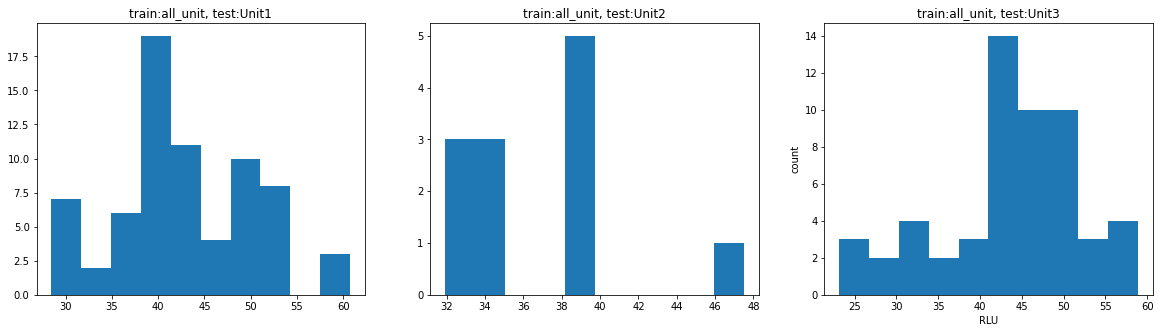

In [51]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.hist(pred_1, bins=10)
ax1.set_title('train:all_unit, test:Unit1')

ax2.hist(pred_2, bins=10)
ax2.set_title('train:all_unit, test:Unit2')

ax3.hist(pred_3, bins=10)
ax3.set_title('train:all_unit, test:Unit3')

plt.xlabel('RLU')
plt.ylabel('count')
plt.show()

In [54]:
#案外きれいな分布なので、ヒストグラムの平均値をRULと定義
RUL_unit_1 = round(statistics.mean(pred_1))
RUL_unit_2 = round(statistics.mean(pred_2))
RUL_unit_3 = round(statistics.mean(pred_3))

print('RUL_test_unit_1：',RUL_unit_1)
print('RUL_test_unit_2：',RUL_unit_2)
print('RUL_test_unit_3：',RUL_unit_3)

RUL_test_unit_1： 43
RUL_test_unit_2： 37
RUL_test_unit_3： 44


提出

In [53]:
#提出ファイルの読み込み
file_submit = pd.read_csv(os.path.join(DIR, 'data', 'ISID_08_09_2021.csv'))

In [55]:
pd.DataFrame({
    file_submit.columns[0]: [RUL_unit_1],
    file_submit.columns[1]: [RUL_unit_2],
    file_submit.columns[2]: [RUL_unit_3],}).to_csv(os.path.join(DIR, "C0002_27_09_2021_3.csv"), index=False)